In [1]:
%pip install vector ipywidgets matplotlib ipympl
import pandas as pd
import vector
import time
import random
import numpy as np
import random
import math
import uuid
import itertools
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import pyplot as plt
%matplotlib widget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
def sim(pitch, speed, drag, grav=0.05, tick=0.05):
    t = 0
    df = pd.DataFrame(columns=['x', 'y', 'z', 'speed', 'horizontal_speed', 'vertical_speed'])
   
    pitch = pitch / 180 * math.pi
    speed *= tick
    pos = vector.obj(x=0,y=0,z=0)
    vel = vector.obj(x=speed*math.cos(pitch),y=speed*math.sin(pitch),z=0)
    while pos.y >= 0:
        curSpeed = vel.mag
        horizSpeed = math.sqrt(vel.x**2 + vel.z**2)
        vertSpeed = math.sqrt(vel.y**2)
        df.loc[t] = {'x': pos.x, 'y': pos.y, 'z': pos.z, 'speed': curSpeed/tick, 'horizontal_speed': horizSpeed/tick, 'vertical_speed': vertSpeed/tick}
    
        t += tick
        pos += vel
        dragForce = min(drag(vel, pos), curSpeed)

        dragVec = vel / curSpeed * dragForce
        vel -= dragVec
        vel.y -= grav

    return df

def drag_current(vel, pos, drag=0.01):
    return drag * vel.mag

def drag_suggested(vel, pos, drag=0.003):
    # NOTE the varying air density by altitude and the quadratic drag
    return (drag / (1+pos.y/100)) * vel.mag2

interactive(children=(FloatSlider(value=320.0, description='muzzle_speed', max=1600.0, min=40.0, step=40.0), O…

<function __main__.pitch_scan(muzzle_speed)>

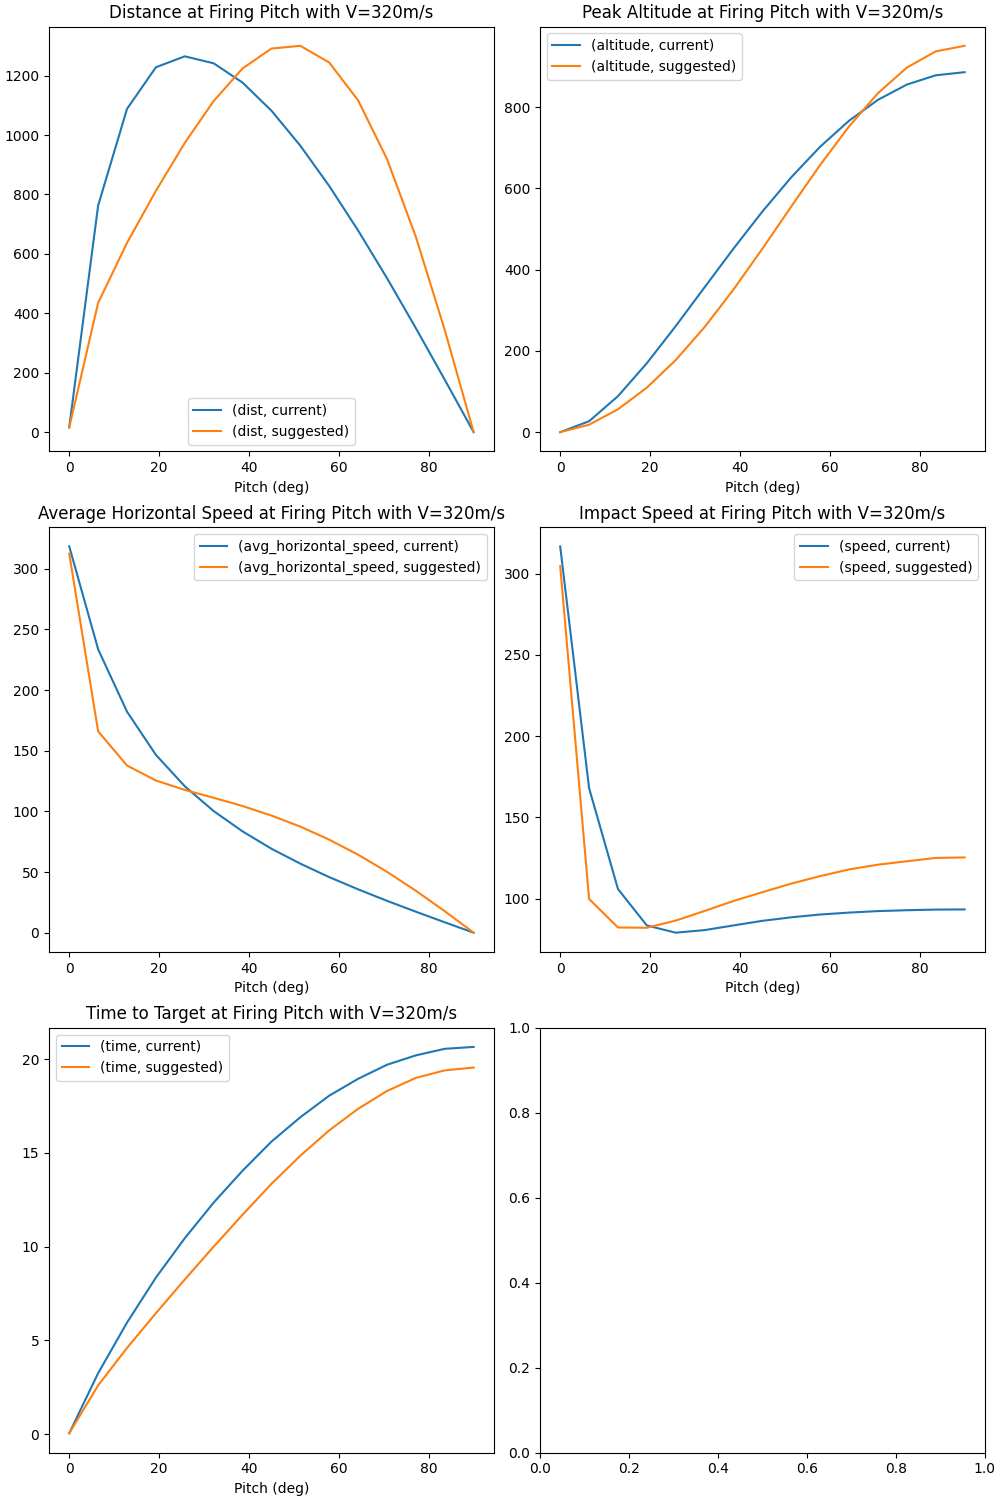

In [16]:
def pitch_scan(muzzle_speed):
    curr = pd.DataFrame(columns=['dist', 'speed', 'avg_horizontal_speed', 'time', 'altitude'])
    sugg = pd.DataFrame(columns=['dist', 'speed', 'avg_horizontal_speed', 'time', 'altitude'])
    for pitch in np.linspace(0,90,15):
        sugg_data = sim(pitch, muzzle_speed, drag_suggested)
        sugg_impact = sugg_data.iloc[-1]
        sugg.loc[pitch] = {'dist': sugg_impact.x, 'speed': sugg_impact.speed, 'avg_horizontal_speed': sugg_data.horizontal_speed.mean(), 'time': sugg_impact.name, 'altitude': sugg_data.y.max()}
        
        curr_data = sim(pitch, muzzle_speed, drag_current)
        curr_impact = curr_data.iloc[-1]
        curr.loc[pitch] = {'dist': curr_impact.x, 'speed': curr_impact.speed, 'avg_horizontal_speed': curr_data.horizontal_speed.mean(), 'time': curr_impact.name, 'altitude': curr_data.y.max()}
    
    #df
    df = pd.concat([curr, sugg], keys=['current', 'suggested'], names=['drag', 'pitch'])
    df = df.unstack('drag')
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15), constrained_layout=True)
    
    ax = df[['dist']].plot.line(ax=axes[0, 0],xlabel='Pitch (deg)', title=f'Distance at Firing Pitch with V={muzzle_speed:0.0f}m/s')
    ax.legend().title=''
    ax=df[['altitude']].plot.line(ax=axes[0,1], xlabel='Pitch (deg)', title=f'Peak Altitude at Firing Pitch with V={muzzle_speed:0.0f}m/s')
    ax.legend().title=''
    ax=df[['avg_horizontal_speed']].plot.line(ax=axes[1,0],xlabel='Pitch (deg)', title=f'Average Horizontal Speed at Firing Pitch with V={muzzle_speed:0.0f}m/s')
    ax.legend().title=''
    ax=df[['speed']].plot.line(ax=axes[1,1], xlabel='Pitch (deg)', title=f'Impact Speed at Firing Pitch with V={muzzle_speed:0.0f}m/s')
    ax.legend().title=''
    ax=df[['time']].plot.line(ax=axes[2,0], xlabel='Pitch (deg)', title=f'Time to Target at Firing Pitch with V={muzzle_speed:0.0f}m/s')
    ax.legend().title=''
    fig.show()

interact(pitch_scan, muzzle_speed = widgets.FloatSlider(value=320,
                                               min=40,
                                               max=1600,
                                               step=40))

interactive(children=(FloatSlider(value=320.0, description='muzzle_speed', max=1600.0, min=40.0, step=40.0), O…

<function __main__.plot_trajectories(muzzle_speed)>

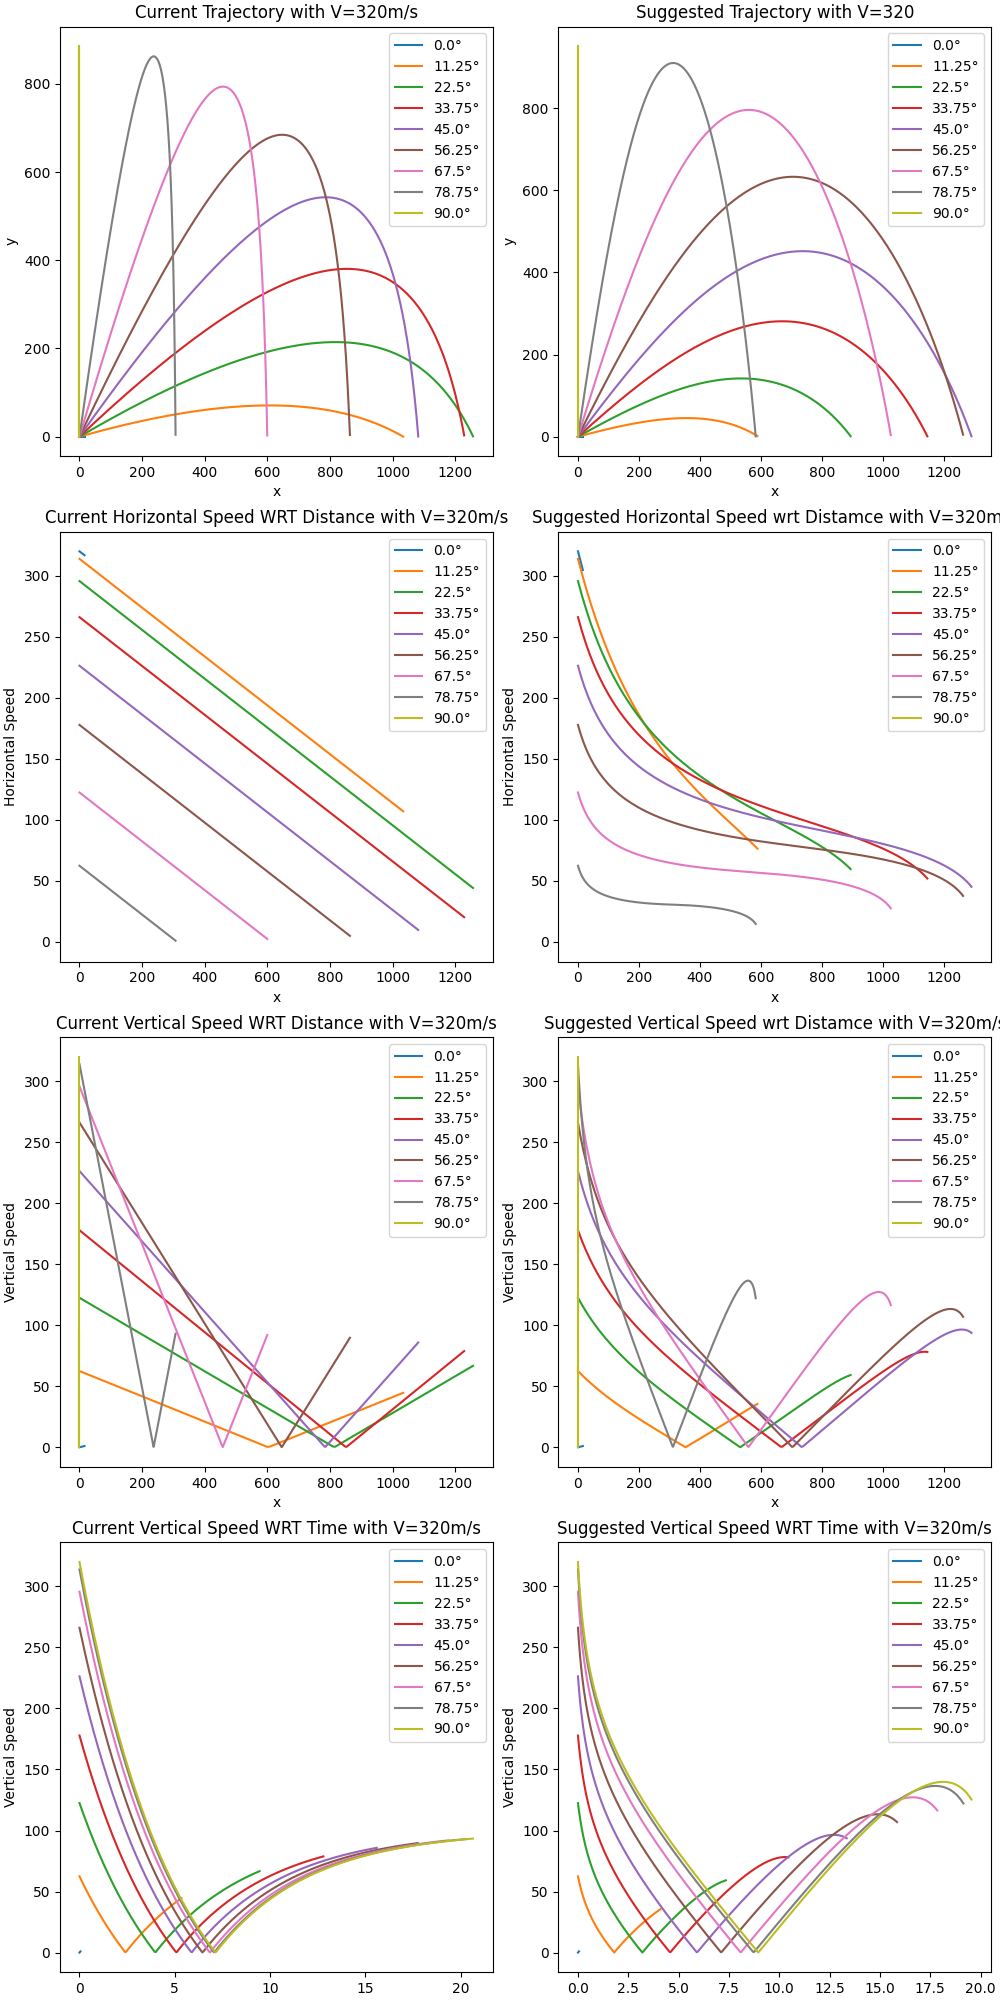

In [17]:
def plot_trajectories(muzzle_speed):
    pitches = np.linspace(0,90,9)
    
    sugg_datas = []
    curr_datas = []
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20), constrained_layout=True)
    
    for pitch in pitches:
        curr_data = sim(pitch, muzzle_speed, drag_current)
        curr_data[['x', 'y']].rename(columns={'y': f'{pitch}°'}).plot.line(x='x', ax=axes[0,0], ylabel='y', title=f'Current Trajectory with V={muzzle_speed:0.0f}m/s')
        curr_data[['horizontal_speed', 'x']].rename(columns={'horizontal_speed': f'{pitch}°'}).plot.line(x='x', ax=axes[1,0], ylabel='Horizontal Speed', title=f'Current Horizontal Speed WRT Distance with V={muzzle_speed:0.0f}m/s')
        curr_data[['vertical_speed', 'x']].rename(columns={'vertical_speed': f'{pitch}°'}).plot.line(x='x', ax=axes[2,0], ylabel='Vertical Speed', title=f'Current Vertical Speed WRT Distance with V={muzzle_speed:0.0f}m/s')
        curr_data[['vertical_speed']].rename(columns={'vertical_speed': f'{pitch}°'}).plot.line(ax=axes[3,0], ylabel='Vertical Speed', title=f'Current Vertical Speed WRT Time with V={muzzle_speed:0.0f}m/s')
        sugg_data = sim(pitch, muzzle_speed, drag_suggested)
        sugg_data[['x', 'y']].rename(columns={'y': f'{pitch}°'}).plot.line(x='x', ax=axes[0,1], ylabel='y', title=f'Suggested Trajectory with V={muzzle_speed:0.0f}')
        sugg_data[['horizontal_speed', 'x']].rename(columns={'horizontal_speed': f'{pitch}°'}).plot.line(x='x', ax=axes[1,1], ylabel='Horizontal Speed', title=f'Suggested Horizontal Speed wrt Distamce with V={muzzle_speed:0.0f}m/s')
        sugg_data[['vertical_speed', 'x']].rename(columns={'vertical_speed': f'{pitch}°'}).plot.line(x='x', ax=axes[2,1], ylabel='Vertical Speed', title=f'Suggested Vertical Speed wrt Distamce with V={muzzle_speed:0.0f}m/s')
        sugg_data[['vertical_speed']].rename(columns={'vertical_speed': f'{pitch}°'}).plot.line(ax=axes[3,1], ylabel='Vertical Speed', title=f'Suggested Vertical Speed WRT Time with V={muzzle_speed:0.0f}m/s')
    fig.show()
interact(plot_trajectories, muzzle_speed = widgets.FloatSlider(value=320,
                                               min=40,
                                               max=1600,
                                               step=40))